In [11]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology
import networkx as nx
import cv2
from collections import defaultdict

def hex_to_rgb(hex_color):
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def color_distance(color1, color2):
    return np.linalg.norm(color1 - color2, axis=-1)

def create_color_mask(img, hex_colors, threshold):
    target_colors = np.array([hex_to_rgb(hex_color) for hex_color in hex_colors])
    distances = np.min(color_distance(img, target_colors[:, np.newaxis, np.newaxis]), axis=0)
    return distances < threshold

def extract_color_areas(img, hex_colors, threshold=50):
    mask = create_color_mask(img, hex_colors, threshold)
    output_image = np.full_like(img, 255)
    output_image[mask] = img[mask]
    return output_image

def remove_color_areas(img, hex_colors, threshold=50):
    mask = create_color_mask(img, hex_colors, threshold)
    output_image = np.copy(img)
    output_image[mask] = [255, 255, 255]
    return output_image

def convert_to_binary(image, threshold=100):
    # Convert the image to grayscale by taking the average of the RGB values
    grayscale_image = np.mean(image, axis=-1)

    # Convert the grayscale image to binary
    # Values less than the threshold become 0 (black), and values greater than or equal to the threshold become 1 (white)
    binary_image = np.where(grayscale_image < threshold, 0, 1)

    return 1-binary_image

def create_graph_from_binary_image(image):
    graph = nx.Graph()
    for row_index, row in enumerate(image):
        for col_index, pixel_value in enumerate(row):
            if pixel_value == 255:
                node = (row_index, col_index)
                graph.add_node(node)
                neighbors = [
                    (row_index - 1, col_index),
                    (row_index + 1, col_index),
                    (row_index, col_index - 1),
                    (row_index, col_index + 1),
                    (row_index - 1, col_index - 1),
                    (row_index - 1, col_index + 1),
                    (row_index + 1, col_index - 1),
                    (row_index + 1, col_index + 1)
                ]
                for neighbor in neighbors:
                    if (
                        0 <= neighbor[0] < image.shape[0]
                        and 0 <= neighbor[1] < image.shape[1]
                        and image[neighbor] == 255
                    ):
                        graph.add_edge(node, neighbor)
    return graph

def simplify_graph(graph, threshold=3):
    def direction(u, v):
        return (v[0] - u[0], v[1] - u[1])

    simplified_graph = nx.Graph()
    edges_to_add = defaultdict(list)

    for u, v in graph.edges():
        edges_to_add[u].append(v)

    while edges_to_add:
        start_node, neighbors = edges_to_add.popitem()
        if not neighbors:
            continue

        current_node = start_node
        current_direction = direction(current_node, neighbors[0])
        straight_path_length = 1

        for next_node in neighbors[1:]:
            next_direction = direction(current_node, next_node)

            if next_direction == current_direction:
                straight_path_length += 1
            else:
                if straight_path_length >= threshold:
                    simplified_graph.add_edge(current_node, neighbors[-1])
                else:
                    simplified_graph.add_edge(current_node, neighbors[0])

                current_node = next_node
                current_direction = next_direction
                straight_path_length = 1

        if straight_path_length >= threshold:
            simplified_graph.add_edge(current_node, neighbors[-1])
        else:
            simplified_graph.add_edge(current_node, neighbors[-1])

        for neighbor in neighbors:
            if neighbor in edges_to_add[start_node]:
                edges_to_add[neighbor].remove(start_node)

    # Remove self-loops
    simplified_graph.remove_edges_from(nx.selfloop_edges(simplified_graph))

    # Remove parallel edges
    simplified_graph = nx.Graph(nx.MultiGraph(simplified_graph).edges())

    # Remove intermediate vertices in straight paths
    nodes_to_remove = set()
    for u, v in simplified_graph.edges():
        if direction(u, v) in [direction(v, w) for w in simplified_graph.neighbors(v)]:
            nodes_to_remove.add(v)

    simplified_graph.remove_nodes_from(nodes_to_remove)

    return simplified_graph


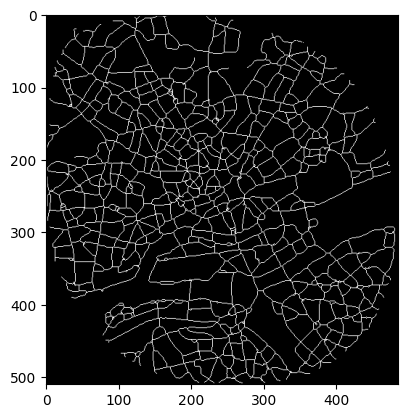

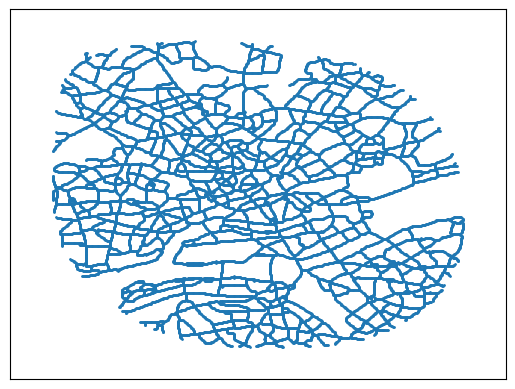

In [12]:
# Load the image using matplotlib
img = plt.imread('Nantes.jpg')

# Define the target hex color and the threshold for color matching
hex_colors = ['0026FF']
threshold = 65

# Uncomment this line if you want to extract areas of the image that match the target color
# img = extract_color_areas(img, hex_colors, threshold)

# Convert the image to a binary (black and white) representation for processing
img = convert_to_binary(img)

# Skeletonize the binary image to reduce features to their basic structure
# This will thin the shapes to 1-pixel-wide skeletons
skeleton = morphology.skeletonize(img)

# Display the skeletonized image using matplotlib
plt.imshow(skeleton, cmap='gray')
plt.show()

# Optionally save the skeletonized image (uncomment if needed)
# cv2.imwrite('output.png', skeleton * 255)

# Create a graph from the skeletonized binary image
# The nodes of the graph represent the white pixels (value = 255)
graph = create_graph_from_binary_image(skeleton * 255)



# Get the height of the skeleton image (used for positioning the graph)
height = skeleton.shape[0]
# Generate the position of each node for graph visualization
# Each node's position is based on its pixel coordinates in the image
pos = {node: (node[1], height - node[0]) for node in graph.nodes()}
# Draw
nx.draw_networkx_nodes(graph, pos, node_size=1)
nx.draw_networkx_edges(graph, pos, width=0.1, alpha=0.5)

# Show the final graph visualization using matplotlib
plt.show()